# Poultry Audio Classification with Deep Learning and Burn Layer Fusion

This notebook implements a deep learning-based approach for classifying poultry audio signals, inspired by the paper "Optimizing poultry audio signal classification with deep learning and burn layer fusion".

The model uses a custom Burn Layer to enhance robustness by injecting controlled random noise during training.

## Import Libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Custom Burn Layer Implementation

The Burn Layer is a key innovation from the paper that adds controlled random noise during training to improve model robustness.

In [ ]:
class BurnLayer(layers.Layer):
    def __init__(self, burn_intensity=0.2, **kwargs):
        super(BurnLayer, self).__init__(**kwargs)
        self.burn_intensity = burn_intensity
    
    def call(self, inputs, training=None):

        if training:

            return inputs + self.burn_intensity * tf.random.normal(shape=tf.shape(inputs))
        else:

            return inputs
    
    def get_config(self):
        config = super(BurnLayer, self).get_config()
        config.update({"burn_intensity": self.burn_intensity})
        return config

## Audio Feature Extraction and Preprocessing

In [3]:
def extract_features(audio_path, sr=44100, duration=2.0, n_mfcc=20):
    """
    Extract audio features from a file
    """
    try:
        # Load audio file with specified sample rate and duration
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)
        
        # If audio is shorter than duration, pad it
        if len(y) < int(duration * sr):
            y = np.pad(y, (0, int(duration * sr) - len(y)))
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Extract chromagram
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Extract spectral contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # Calculate Melspectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        return y, sr, mfccs, mel_spec_db, chroma, contrast
        
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {e}")
        return None, None, None, None, None, None

def load_and_preprocess_data(data_path, sr=44100, duration=2.0, n_mfcc=20):
    """
    Load and preprocess all audio files in the dataset
    """
    X_mel = []
    y = []
    file_paths = []
    classes = ['Healthy', 'Noise', 'Unhealthy']
    class_counts = {}
    
    for i, category in enumerate(classes):
        path = os.path.join(data_path, category)
        print(f"Loading {category} samples...")
        count = 0
        
        for filename in os.listdir(path):
            if not filename.lower().endswith('.wav'):
                continue
                
            file_path = os.path.join(path, filename)
            _, _, _, mel_spec_db, _, _ = extract_features(file_path, sr=sr, duration=duration, n_mfcc=n_mfcc)
            
            if mel_spec_db is not None:
                X_mel.append(mel_spec_db)
                y.append(i)
                file_paths.append(file_path)
                count += 1
        
        class_counts[category] = count
        print(f"  Loaded {count} samples for {category}")
    
    X_mel = np.array(X_mel)
    y = np.array(y)
    
    # Reshape mel spectrograms for CNN input
    X_mel = X_mel.reshape(X_mel.shape[0], X_mel.shape[1], X_mel.shape[2], 1)
    
    return X_mel, y, file_paths, class_counts

## Data Augmentation Functions

These functions will help create more training samples and improve model generalization.

In [4]:
def augment_data(X_mel, y, augmentation_factor=2):
    """
    Perform data augmentation on mel spectrograms
    """
    X_aug = []
    y_aug = []
    
    # First include all original samples
    for i in range(len(X_mel)):
        X_aug.append(X_mel[i])
        y_aug.append(y[i])
    
    # Then create augmented versions
    for i in range(len(X_mel)):
        mel_spec = X_mel[i].squeeze()
        
        # Create augmentation_factor-1 augmented versions
        for _ in range(augmentation_factor - 1):
            aug_mel_spec = mel_spec.copy()
            
            # Add random noise
            noise_factor = np.random.uniform(0.005, 0.02)
            noise = np.random.normal(0, noise_factor, aug_mel_spec.shape)
            aug_mel_spec = aug_mel_spec + noise
            
            # Shift in time (roll)
            shift_amount = np.random.randint(-10, 10)
            aug_mel_spec = np.roll(aug_mel_spec, shift_amount, axis=1)
            
            # Frequency masking (mask random frequency bands)
            if np.random.random() > 0.5:
                num_masks = np.random.randint(1, 3)
                for _ in range(num_masks):
                    f0 = np.random.randint(0, aug_mel_spec.shape[0] - 5)
                    f_width = np.random.randint(1, 5)
                    aug_mel_spec[f0:f0+f_width, :] = aug_mel_spec.min()
            
            # Time masking (mask random time segments)
            if np.random.random() > 0.5:
                num_masks = np.random.randint(1, 3)
                for _ in range(num_masks):
                    t0 = np.random.randint(0, aug_mel_spec.shape[1] - 5)
                    t_width = np.random.randint(1, 5)
                    aug_mel_spec[:, t0:t0+t_width] = aug_mel_spec.min()
            
            # Ensure values are valid
            aug_mel_spec = np.clip(aug_mel_spec, -80, 0)
            
            # Add to augmented data
            X_aug.append(aug_mel_spec.reshape(X_mel[i].shape))
            y_aug.append(y[i])
    
    return np.array(X_aug), np.array(y_aug)

## Visualization Functions

In [5]:
def visualize_audio(file_path, sr=44100, duration=2.0):
    """
    Visualize audio file with waveform, MFCC, and Mel Spectrogram
    """
    # Extract features
    y, sr, mfccs, mel_spec_db, chroma, contrast = extract_features(file_path, sr=sr, duration=duration)
    
    if y is None:
        print(f"Could not load audio file: {file_path}")
        return
    
    # Create figure with 4 subplots
    plt.figure(figsize=(15, 12))
    
    # Plot waveform
    plt.subplot(4, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    
    # Plot MFCC
    plt.subplot(4, 1, 2)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs')
    
    # Plot Mel Spectrogram
    plt.subplot(4, 1, 3)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    
    # Plot Chromagram
    plt.subplot(4, 1, 4)
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram')
    
    plt.tight_layout()
    plt.show()

def visualize_augmentation(X_mel, index, augmentation_factor=3):
    """
    Visualize original and augmented mel spectrograms
    """
    # Get original mel spectrogram
    original_mel = X_mel[index].squeeze()
    
    # Create augmented versions
    augmented_mels = []
    for _ in range(augmentation_factor):
        aug_mel = original_mel.copy()
        
        # Add random noise
        noise_factor = np.random.uniform(0.005, 0.02)
        noise = np.random.normal(0, noise_factor, aug_mel.shape)
        aug_mel = aug_mel + noise
        
        # Shift in time (roll)
        shift_amount = np.random.randint(-10, 10)
        aug_mel = np.roll(aug_mel, shift_amount, axis=1)
        
        # Frequency masking
        if np.random.random() > 0.5:
            f0 = np.random.randint(0, aug_mel.shape[0] - 5)
            f_width = np.random.randint(1, 5)
            aug_mel[f0:f0+f_width, :] = aug_mel.min()
        
        # Time masking
        if np.random.random() > 0.5:
            t0 = np.random.randint(0, aug_mel.shape[1] - 5)
            t_width = np.random.randint(1, 5)
            aug_mel[:, t0:t0+t_width] = aug_mel.min()
        
        augmented_mels.append(aug_mel)
    
    # Visualize original and augmented spectrograms
    plt.figure(figsize=(15, 10))
    
    # Original
    plt.subplot(2, 2, 1)
    librosa.display.specshow(original_mel, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Mel Spectrogram')
    
    # Augmented versions
    for i, aug_mel in enumerate(augmented_mels):
        plt.subplot(2, 2, i+2)
        librosa.display.specshow(aug_mel, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Augmented Version {i+1}')
    
    plt.tight_layout()
    plt.show()

## Model Architecture

This model implements the architecture described in the paper, with convolutional blocks, Burn Layer, and global average pooling.

In [28]:
def build_burn_model(input_shape, num_classes=3):
    """
    Build the model with Burn Layer as described in the paper
    """
    # Input tensor
    inputs = layers.Input(shape=input_shape)
    
    # Apply initial Burn Layer to input
    x = BurnLayer(burn_intensity=0.2)(inputs)
    
    # First convolutional block
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Second convolutional block
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Third convolutional block
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Global average pooling to create a fusion layer
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layer
    x = layers.Dense(256)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.6)(x)
    
    # Second Burn Layer with reduced intensity
    x = BurnLayer(burn_intensity=0.1)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile with Adamax optimizer as used in the paper
    model.compile(
        optimizer=optimizers.Adamax(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Training Functions

In [29]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    Train the model with early stopping and model checkpointing
    """
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_poultry_audio_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    return history

def k_fold_cross_validation(X, y, n_splits=5, epochs=50, batch_size=16):
    """
    Perform k-fold cross-validation
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nTraining Fold {fold+1}/{n_splits}")
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Build and train model
        model = build_burn_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(y)))
        history = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
        
        # Evaluate model
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        fold_results.append((val_loss, val_acc))
        
        print(f"Fold {fold+1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Calculate average results
    avg_loss = np.mean([res[0] for res in fold_results])
    avg_acc = np.mean([res[1] for res in fold_results])
    std_acc = np.std([res[1] for res in fold_results])
    
    print(f"\nCross-Validation Results:")
    print(f"Average Validation Loss: {avg_loss:.4f}")
    print(f"Average Validation Accuracy: {avg_acc:.4f} ± {std_acc:.4f}")
    
    return fold_results, avg_acc, std_acc

## Evaluation Functions

In [30]:
def evaluate_model(model, X_test, y_test, class_names):
    """
    Evaluate the model and calculate metrics mentioned in the paper
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics mentioned in the paper
    n_classes = len(class_names)
    
    # Initialize arrays for metrics
    sensitivity = np.zeros(n_classes)
    specificity = np.zeros(n_classes)
    precision = np.zeros(n_classes)
    npv = np.zeros(n_classes)
    f1 = np.zeros(n_classes)
    mcc = np.zeros(n_classes)
    
    # Calculate per-class metrics
    for i in range(n_classes):
        # True positives, false positives, true negatives, false negatives
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        
        # Calculate metrics
        sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0
        npv[i] = TN / (TN + FN) if (TN + FN) > 0 else 0
        
        # F1 score
        f1[i] = 2 * (precision[i] * sensitivity[i]) / (precision[i] + sensitivity[i]) if (precision[i] + sensitivity[i]) > 0 else 0
        
        # Matthews Correlation Coefficient
        mcc_numerator = (TP * TN - FP * FN)
        mcc_denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) > 0 else 1
        mcc[i] = mcc_numerator / mcc_denominator
    
    # Print per-class metrics
    print("\nPer-Class Metrics:")
    for i in range(n_classes):
        print(f"\n{class_names[i]}:")
        print(f"  Sensitivity: {sensitivity[i] * 100:.2f}%")
        print(f"  Specificity: {specificity[i] * 100:.2f}%")
        print(f"  Precision: {precision[i] * 100:.2f}%")
        print(f"  NPV: {npv[i] * 100:.2f}%")
        print(f"  F1 Score: {f1[i] * 100:.2f}%")
        print(f"  MCC: {mcc[i] * 100:.2f}%")
    
    # Average metrics
    print("\nAverage Metrics:")
    print(f"  Sensitivity: {np.mean(sensitivity) * 100:.2f}%")
    print(f"  Specificity: {np.mean(specificity) * 100:.2f}%")
    print(f"  Precision: {np.mean(precision) * 100:.2f}%")
    print(f"  NPV: {np.mean(npv) * 100:.2f}%")
    print(f"  F1 Score: {np.mean(f1) * 100:.2f}%")
    print(f"  MCC: {np.mean(mcc) * 100:.2f}%")
    
    return {
        'accuracy': accuracy,
        'sensitivity': np.mean(sensitivity),
        'specificity': np.mean(specificity),
        'precision': np.mean(precision),
        'npv': np.mean(npv),
        'f1': np.mean(f1),
        'mcc': np.mean(mcc)
    }

## Prediction Function for New Audio

In [31]:
def predict_audio(model, audio_path, sr=44100, duration=2.0, n_mfcc=20, classes=['Healthy', 'Noise', 'Unhealthy']):
    """
    Predict the class of a new audio file
    """
    # Extract features
    _, _, _, mel_spec_db, _, _ = extract_features(audio_path, sr=sr, duration=duration, n_mfcc=n_mfcc)
    
    if mel_spec_db is None:
        print(f"Could not process audio file: {audio_path}")
        return None
    
    # Reshape for model input
    mel_spec_db = mel_spec_db.reshape(1, mel_spec_db.shape[0], mel_spec_db.shape[1], 1)
    
    # Make prediction
    pred = model.predict(mel_spec_db)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = pred[0][pred_class]
    
    print(f"Predicted class: {classes[pred_class]} (Confidence: {confidence * 100:.2f}%)")
    print("\nClass probabilities:")
    for i, cls in enumerate(classes):
        print(f"  {cls}: {pred[0][i] * 100:.2f}%")
    
    # Visualize the audio
    visualize_audio(audio_path, sr=sr, duration=duration)
    
    return classes[pred_class], confidence

## Main Execution

In [10]:
# Set the path to your dataset
data_path = 'Chicken_Audio_Dataset'

# Set hyperparameters from the paper
sr = 44100  # Sample rate
duration = 2.0  # Duration in seconds
n_mfcc = 20  # Number of MFCC features
n_epochs = 50
batch_size = 16
classes = ['Healthy', 'Noise', 'Unhealthy']

In [11]:
# Load and preprocess data
print("Loading and preprocessing data...")
X_mel, y, file_paths, class_counts = load_and_preprocess_data(data_path, sr=sr, duration=duration, n_mfcc=n_mfcc)

print(f"\nTotal dataset size: {len(X_mel)} samples")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} samples")

Loading and preprocessing data...
Loading Healthy samples...
  Loaded 139 samples for Healthy
Loading Noise samples...
  Loaded 86 samples for Noise
Loading Unhealthy samples...
  Loaded 121 samples for Unhealthy

Total dataset size: 346 samples
  Healthy: 139 samples
  Noise: 86 samples
  Unhealthy: 121 samples



Visualizing a sample from the Healthy class:


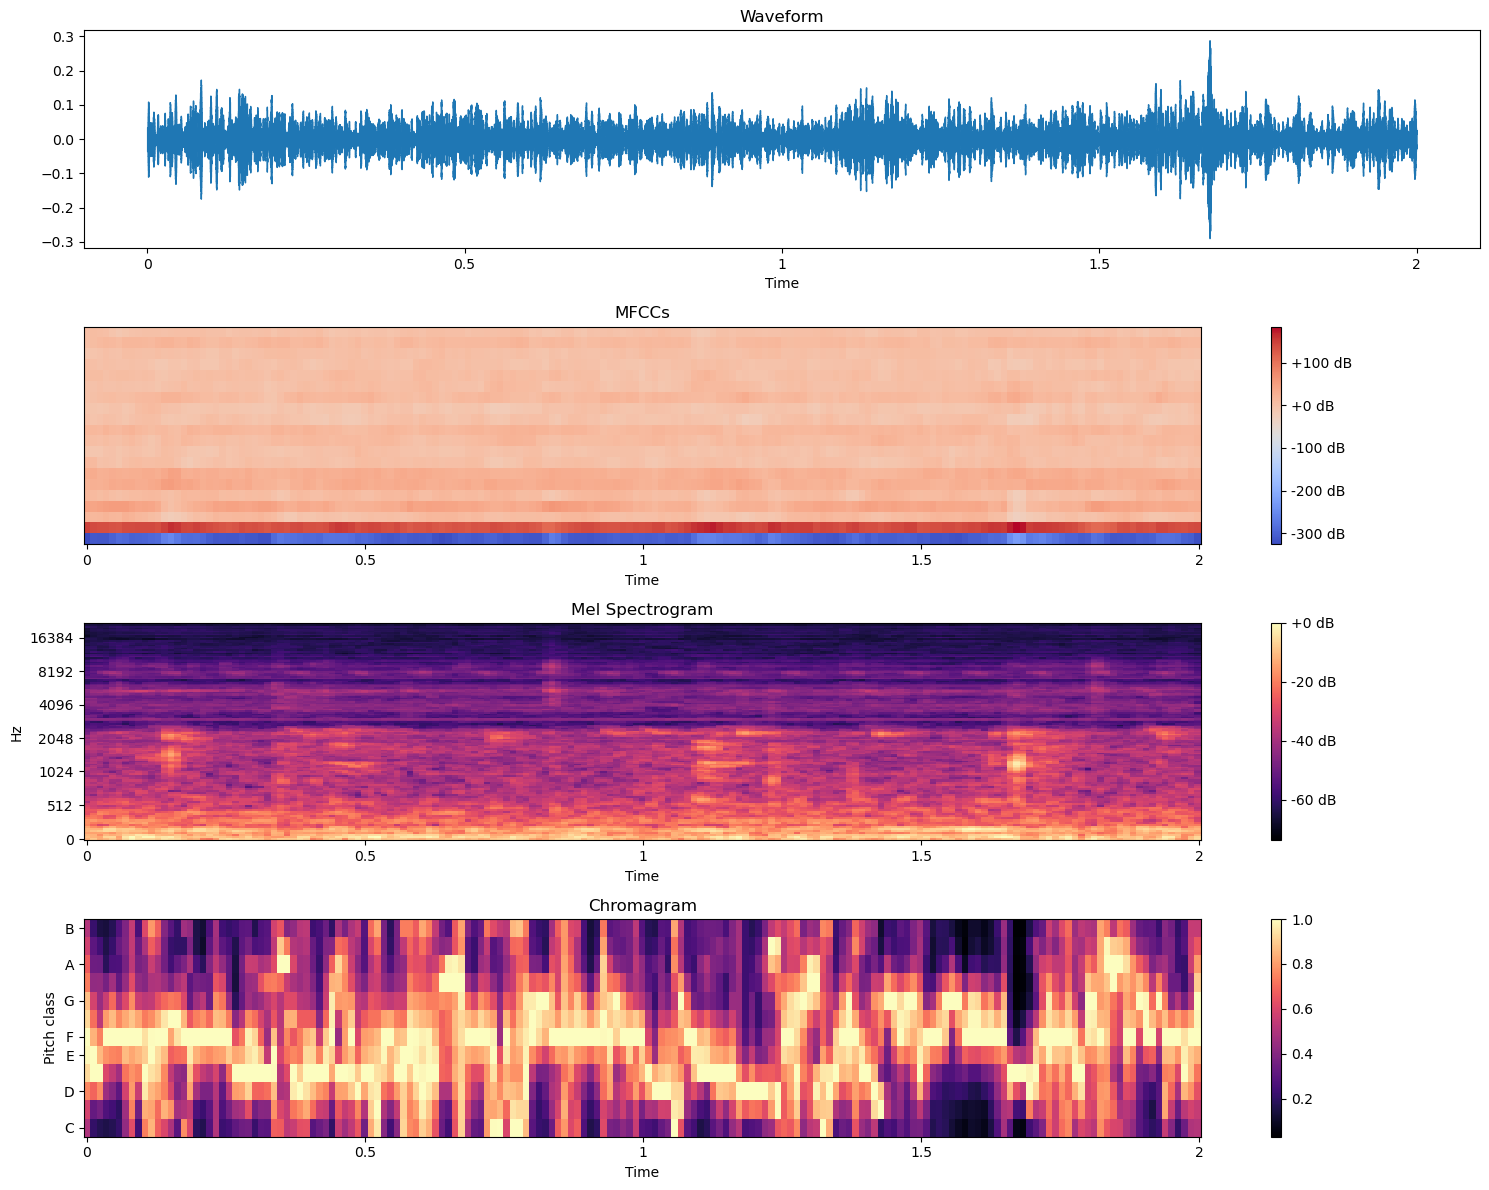


Visualizing a sample from the Noise class:


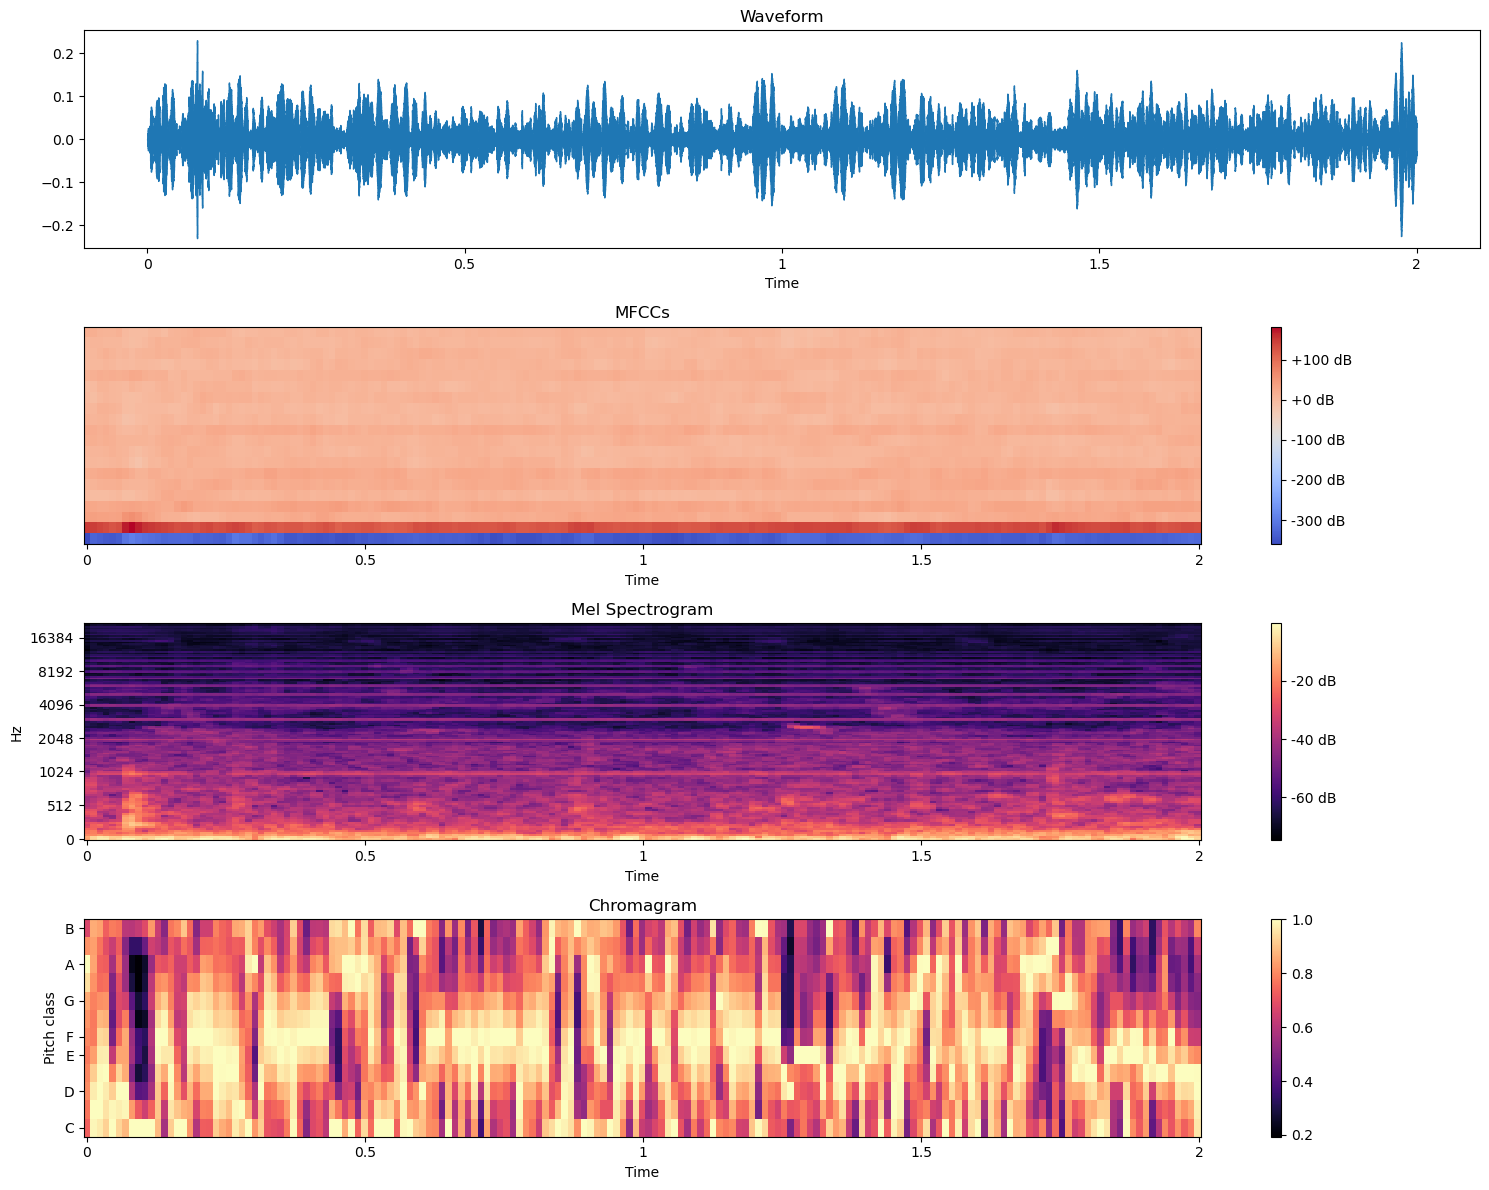


Visualizing a sample from the Unhealthy class:


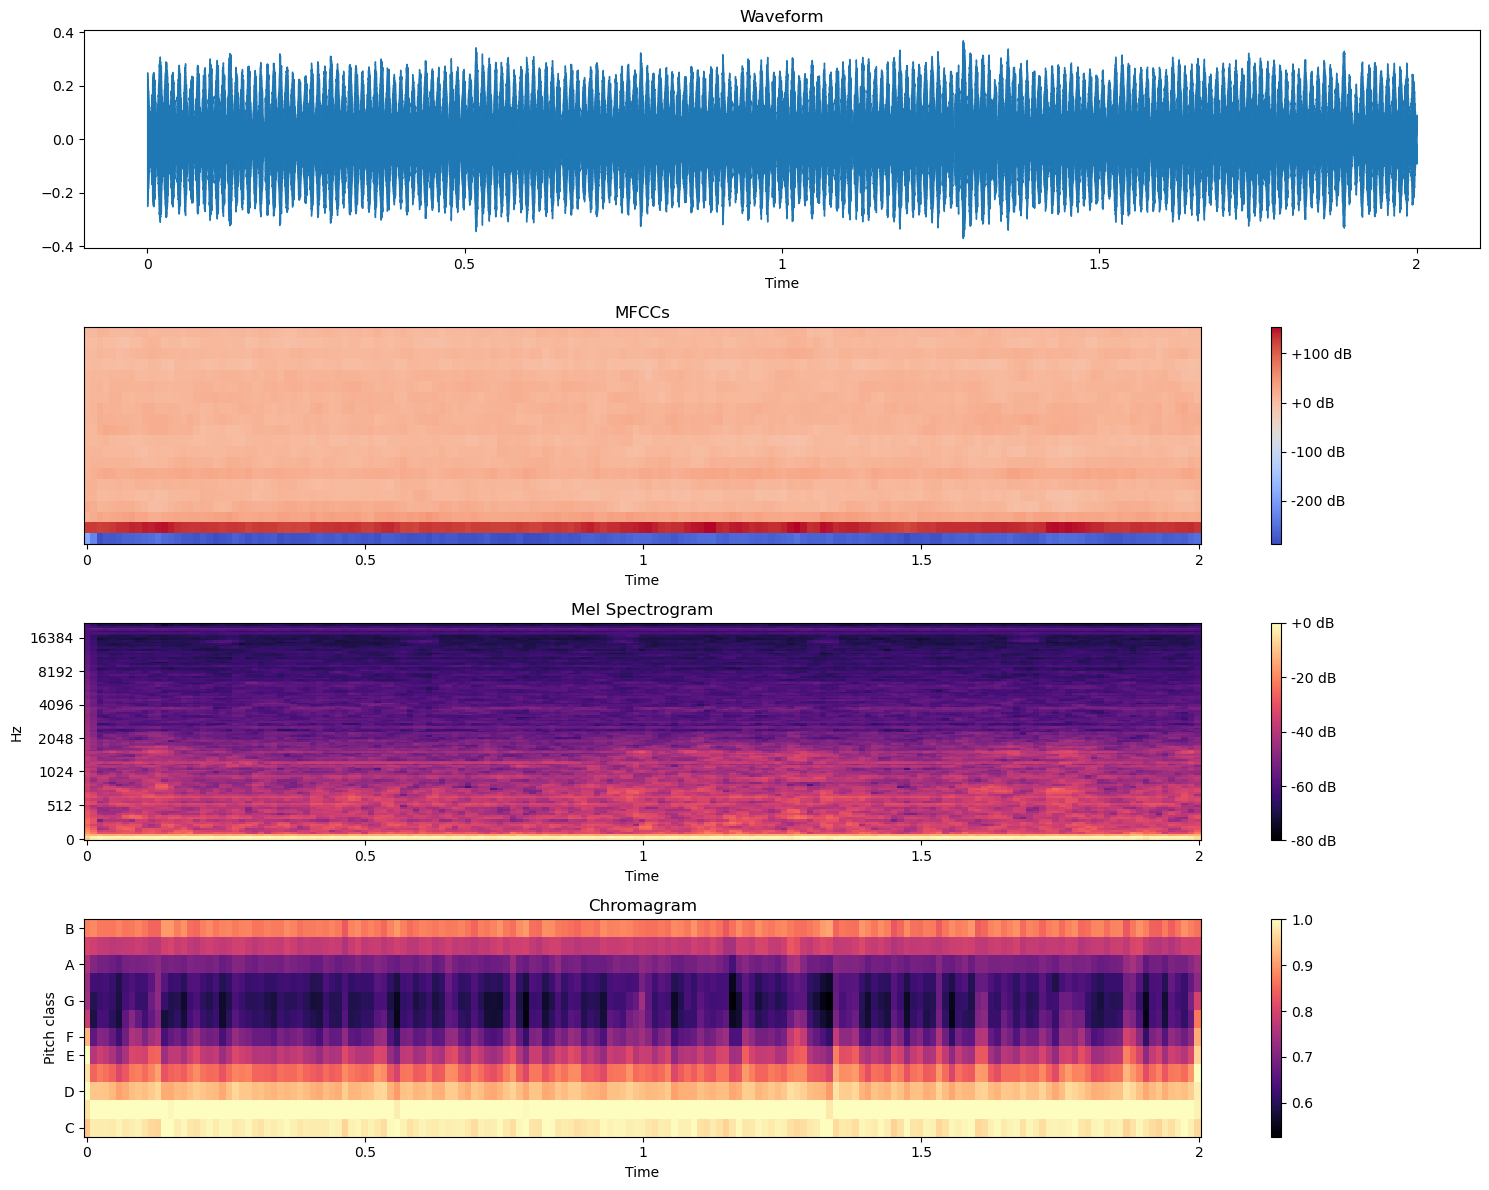

In [32]:
# Visualize samples from each class
for i, class_name in enumerate(classes):
    class_indices = np.where(y == i)[0]
    if len(class_indices) > 0:
        sample_idx = np.random.choice(class_indices)
        print(f"\nVisualizing a sample from the {class_name} class:")
        visualize_audio(file_paths[sample_idx], sr=sr, duration=duration)


Visualizing augmentation for a Healthy sample:


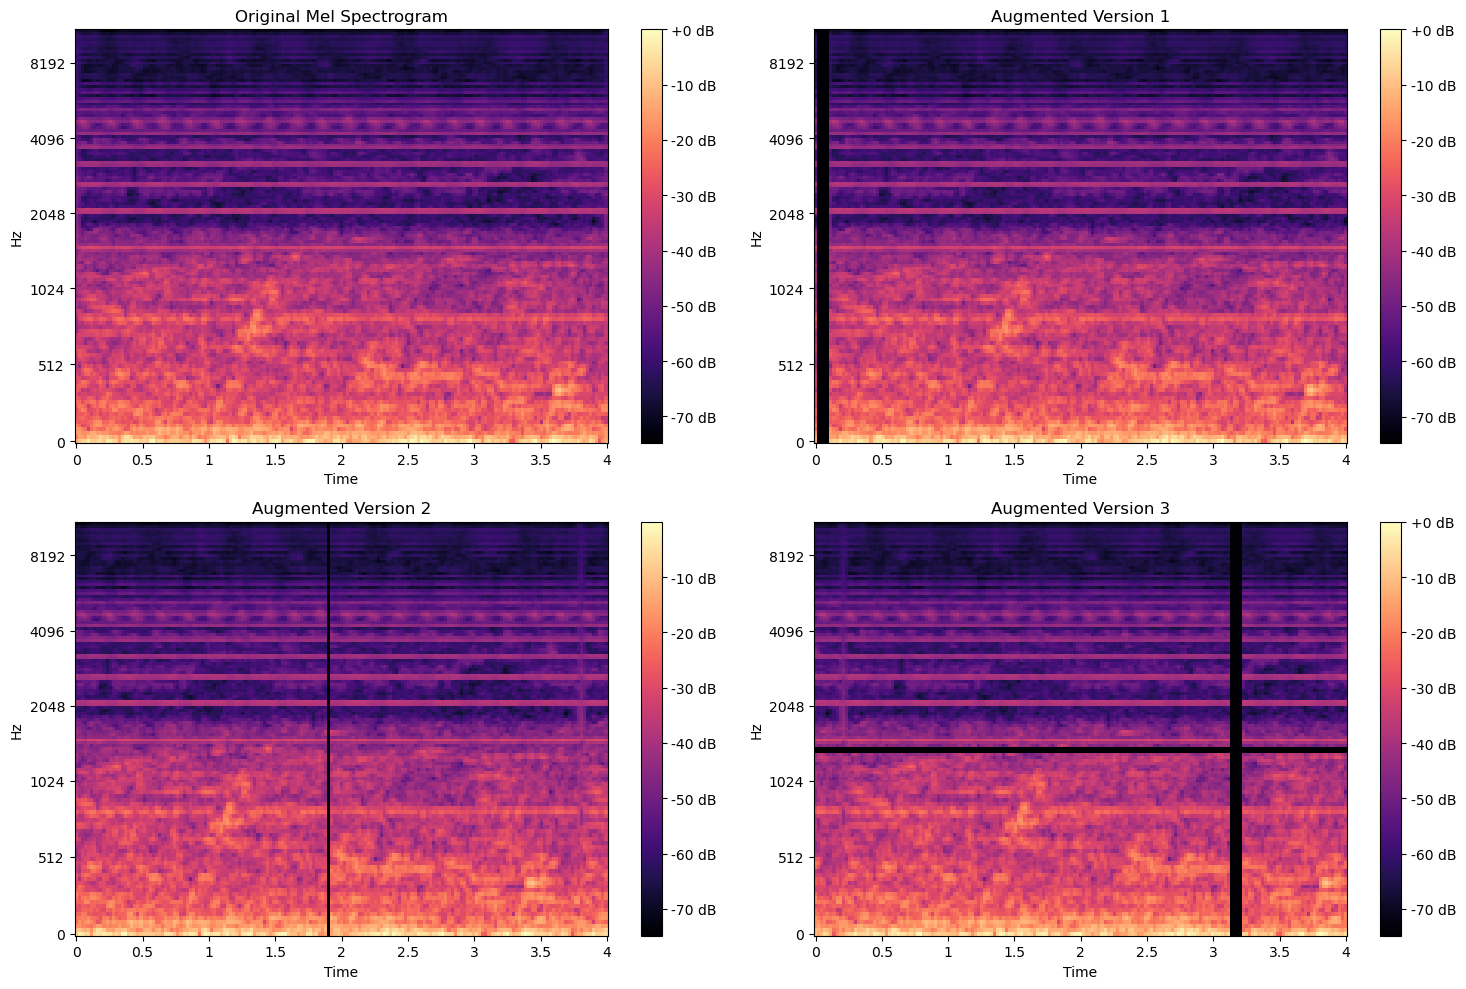


Visualizing augmentation for a Noise sample:


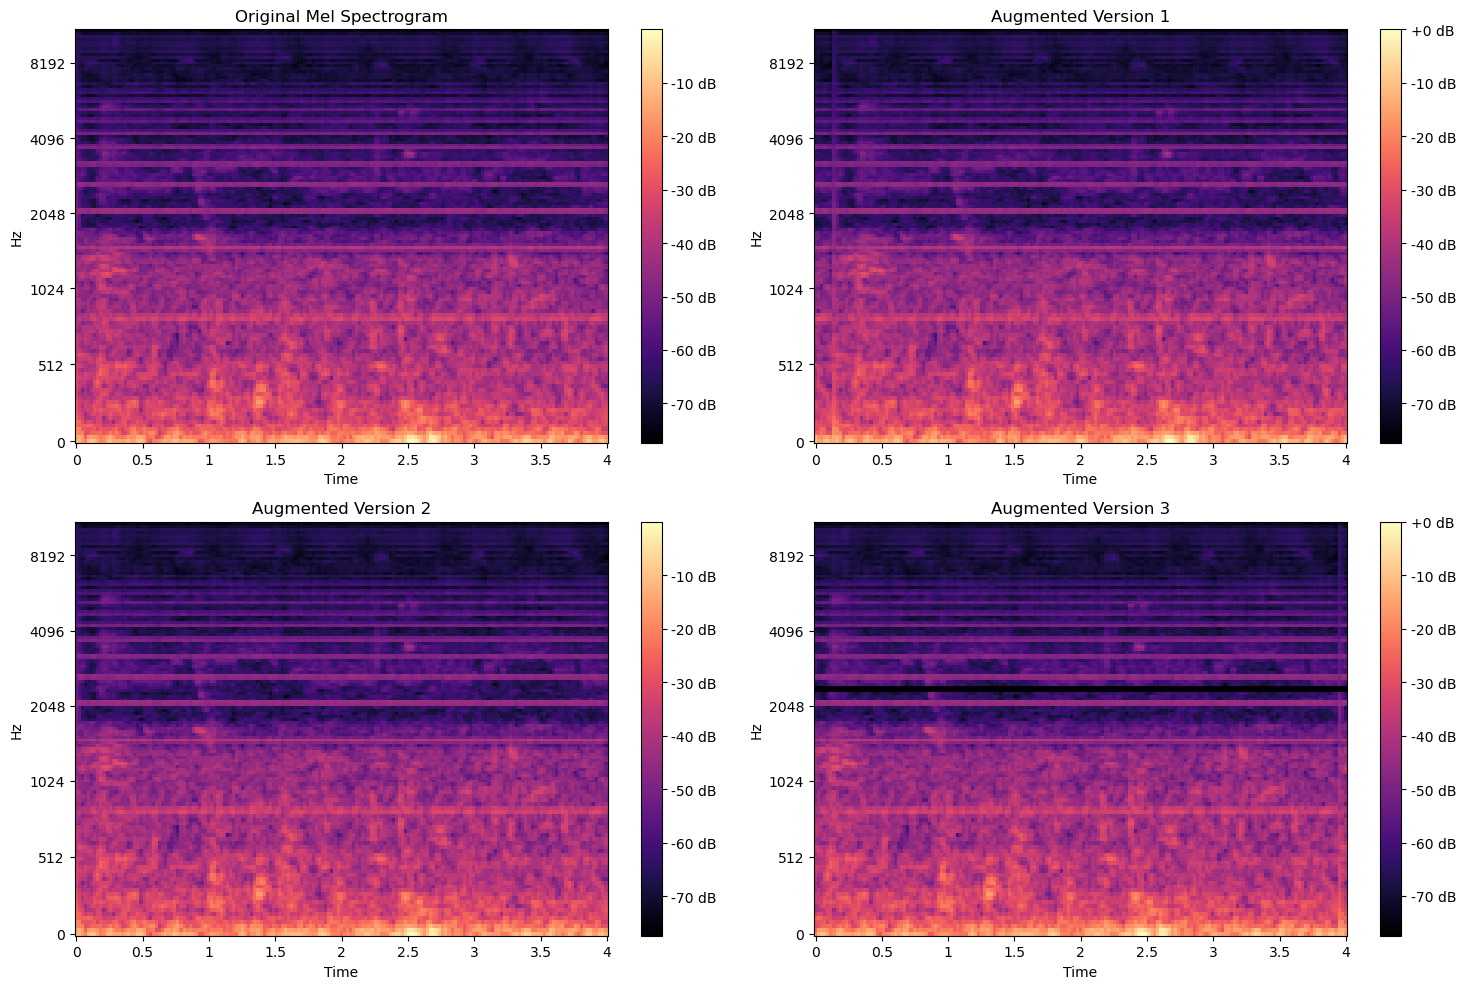


Visualizing augmentation for a Unhealthy sample:


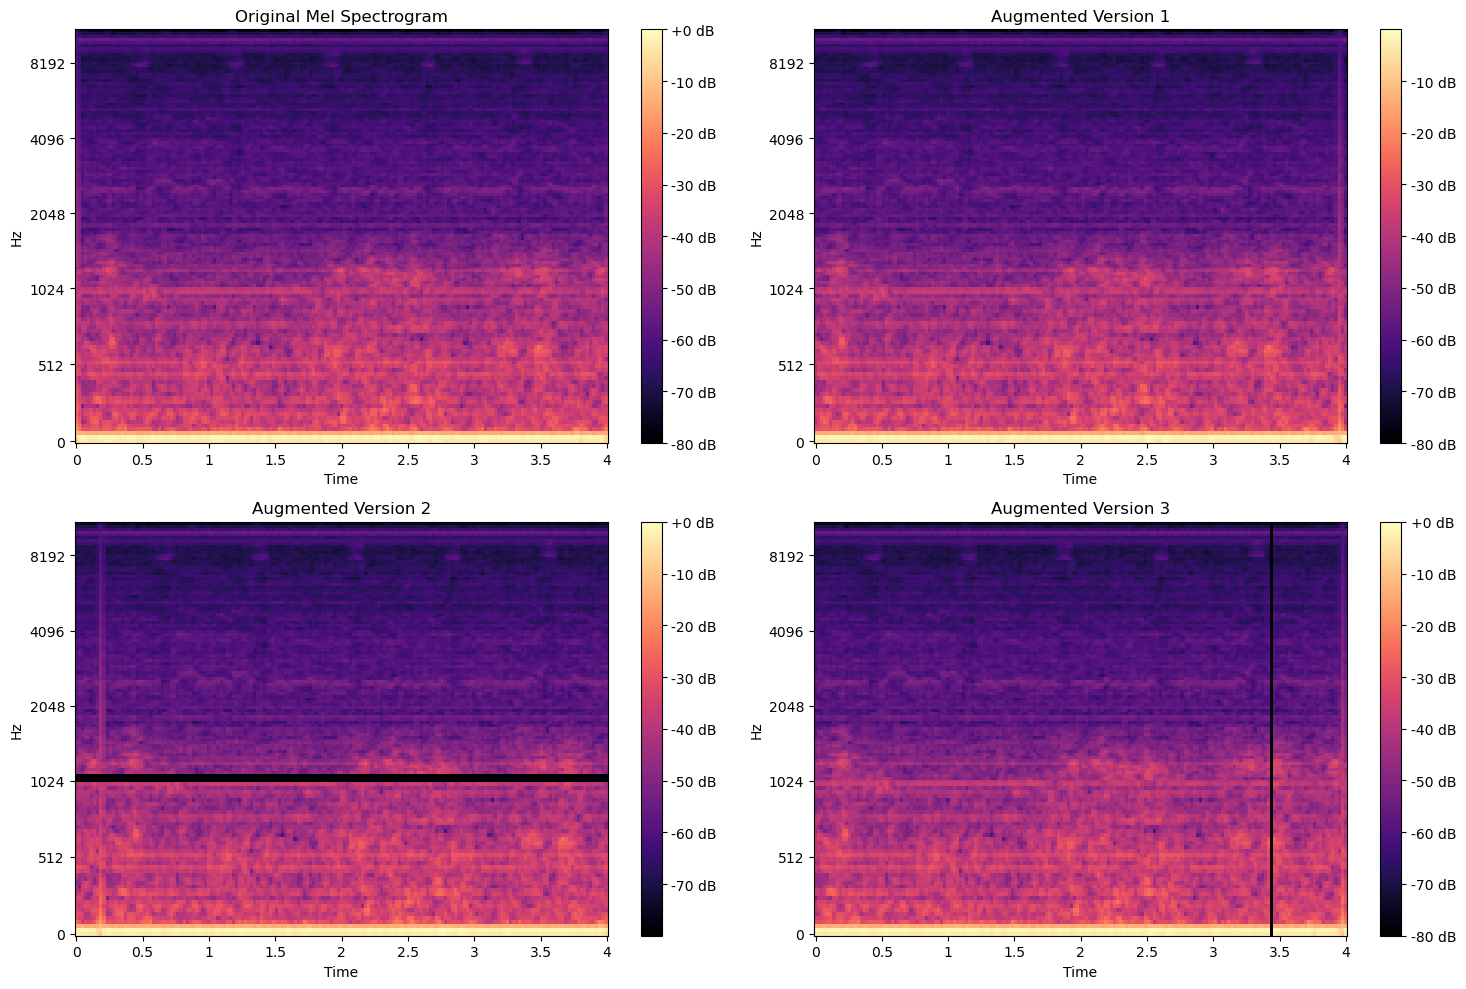

In [13]:
# Visualize data augmentation
for i, class_name in enumerate(classes):
    class_indices = np.where(y == i)[0]
    if len(class_indices) > 0:
        sample_idx = np.random.choice(class_indices)
        print(f"\nVisualizing augmentation for a {class_name} sample:")
        visualize_augmentation(X_mel, sample_idx, augmentation_factor=3)

In [14]:
# Data augmentation
print("\nAugmenting training data...")
X_aug, y_aug = augment_data(X_mel, y, augmentation_factor=2)
print(f"Original dataset size: {len(X_mel)}")
print(f"Augmented dataset size: {len(X_aug)}")

# Class distribution after augmentation
for i, class_name in enumerate(classes):
    print(f"  {class_name}: {np.sum(y_aug == i)} samples")


Augmenting training data...
Original dataset size: 346
Augmented dataset size: 692
  Healthy: 278 samples
  Noise: 172 samples
  Unhealthy: 242 samples


In [15]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Print class distribution
for i, class_name in enumerate(classes):
    print(f"Class {class_name}:")
    print(f"  Training: {np.sum(y_train == i)} samples")
    print(f"  Validation: {np.sum(y_val == i)} samples")
    print(f"  Testing: {np.sum(y_test == i)} samples")


Training set: 484 samples
Validation set: 104 samples
Test set: 104 samples
Class Healthy:
  Training: 195 samples
  Validation: 41 samples
  Testing: 42 samples
Class Noise:
  Training: 120 samples
  Validation: 26 samples
  Testing: 26 samples
Class Unhealthy:
  Training: 169 samples
  Validation: 37 samples
  Testing: 36 samples


In [33]:
# Build the model
print("\nBuilding the model...")
model = build_burn_model(input_shape=X_train.shape[1:], num_classes=len(classes))
model.summary()


Building the model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 173, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ burn_layer_9 (BurnLayer)        │ (None, 128, 173, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 173, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 173, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128, 173, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 86, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 86, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64, 86, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 43, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 43, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32, 43, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 21, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ burn_layer_10 (BurnLayer)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,019 (1.67 MB)

 Trainable params: 437,123 (1.67 MB)

 Non-trainable params: 896 (3.50 KB)

In [34]:
# Train the model
print("\nTraining the model...")
history = train_model(model, X_train, y_train, X_val, y_val, epochs=n_epochs, batch_size=batch_size)


Training the model...
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4608 - loss: 1.4103

31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4617 - loss: 1.4092 - val_accuracy: 0.3558 - val_loss: 6.5874
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5645 - loss: 1.1977

31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5641 - loss: 1.1980 - val_accuracy: 0.4231 - val_loss: 3.1828
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6334 - loss: 1.0870 - val_accuracy: 0.3558 - val_loss: 1.9705
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7240 - loss: 0.9791

31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7234 - loss: 0.9798 - val_accuracy: 0.4327 - val_loss: 1.6946
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7078 - loss: 0.9700 - val_accuracy: 0.2500 - val_loss: 1.4288
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7382 - loss: 0.8742 - val_accuracy: 0.4135 - val_loss: 1.2446
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7737 - loss: 0.8104

31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7732 - loss: 0.8111 - val_accuracy: 0.4808 - val_loss: 1.4213
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8138 - loss: 0.7642

31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8131 - loss: 0.7651 - val_accuracy: 0.5000 - val_loss: 1.3824
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8393 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 1.7545
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8416 - loss: 0.6523 - val_accuracy: 0.4808 - val_loss: 2.0222
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8645 - loss: 0.6147 - val_accuracy: 0.4808 - val_loss: 2.6428
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8476 - loss: 0.6001 - val_accuracy: 0.4904 - val_loss: 2.3608
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8889 - loss: 0.5724 - val_accuracy: 0.3269 - val_loss: 3.5042
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8829 - loss: 0.5413 - val_accuracy: 0.2692 - val_loss: 3.1362
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8938 - loss: 0.5267

31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8941 - loss: 0.5263 - val_accuracy: 0.6538 - val_loss: 0.9608
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9088 - loss: 0.4925 - val_accuracy: 0.5096 - val_loss: 1.3794
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9284 - loss: 0.4736 - val_accuracy: 0.4615 - val_loss: 1.7271
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9118 - loss: 0.4556 - val_accuracy: 0.5769 - val_loss: 1.2592
Epoch 19/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9235 - loss: 0.4516 - val_accuracy: 0.5673 - val_loss: 1.7352
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9118 - loss: 0.4577 - val_accuracy: 0.6442 - val_loss: 0.9551
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9122 - loss: 0.4560 - val_accuracy: 0.3846 - val_loss: 2.1968
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9390 - loss: 0.4300

31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9391 - loss: 0.4296 - val_accuracy: 0.8750 - val_loss: 0.6194
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9067 - loss: 0.4331 - val_accuracy: 0.6346 - val_loss: 1.0294
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9292 - loss: 0.4067 - val_accuracy: 0.8654 - val_loss: 0.6255
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9337 - loss: 0.3813 - val_accuracy: 0.7885 - val_loss: 0.7486
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9539 - loss: 0.3785 - val_accuracy: 0.3173 - val_loss: 2.6048
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9380 - loss: 0.3930 - val_accuracy: 0.7692 - val_loss: 0.7377
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9540 - loss: 0.3704 - val_accuracy: 0.8077 - val_loss: 0.8108
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9534 - loss: 0.3585 - val_accuracy: 0.5000 - val_loss: 2.4

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9426 - loss: 0.3935 - val_accuracy: 0.9038 - val_loss: 0.5399
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9652 - loss: 0.3140 - val_accuracy: 0.5288 - val_loss: 2.2029
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9636 - loss: 0.3161 - val_accuracy: 0.4904 - val_loss: 2.2885
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9718 - loss: 0.3194

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9721 - loss: 0.3189 - val_accuracy: 0.9327 - val_loss: 0.6154
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9569 - loss: 0.3238 - val_accuracy: 0.8750 - val_loss: 0.5670
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9604 - loss: 0.3221 - val_accuracy: 0.8558 - val_loss: 0.6092
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9600 - loss: 0.3127 - val_accuracy: 0.5577 - val_loss: 1.6855
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9727 - loss: 0.2964 - val_accuracy: 0.6827 - val_loss: 1.0421
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9579 - loss: 0.3137 - val_accuracy: 0.6731 - val_loss: 0.9649
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9757 - loss: 0.2698 - val_accuracy: 0.6058 - val_loss: 1.2583
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9685 - loss: 0.3080 - val_accuracy: 0.7115 - val_loss: 0.8

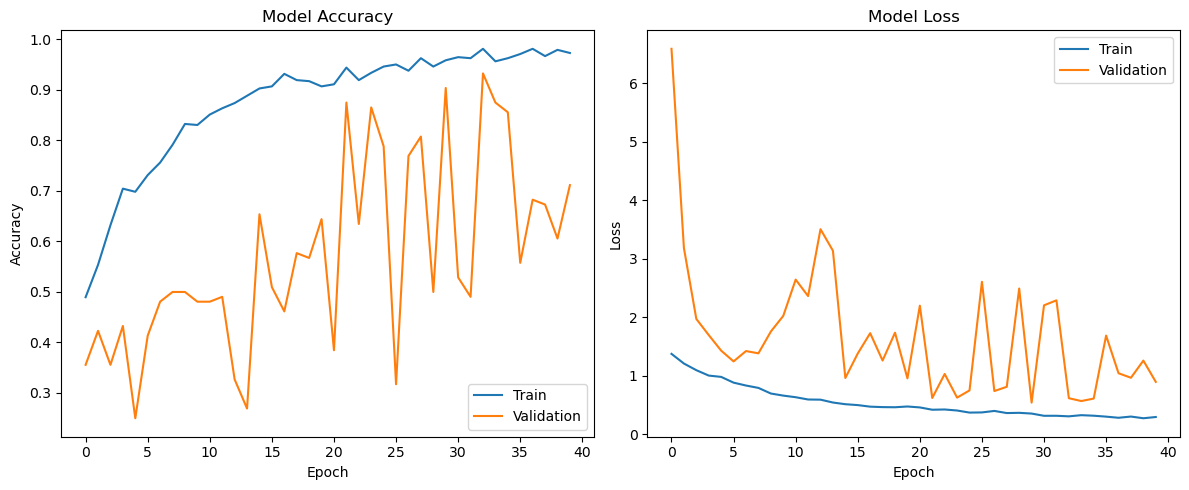

In [35]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


Evaluating the model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step
Test Accuracy: 90.38%

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.95      0.92        42
       Noise       1.00      0.69      0.82        26
   Unhealthy       0.88      1.00      0.94        36

    accuracy                           0.90       104
   macro avg       0.92      0.88      0.89       104
weighted avg       0.91      0.90      0.90       104



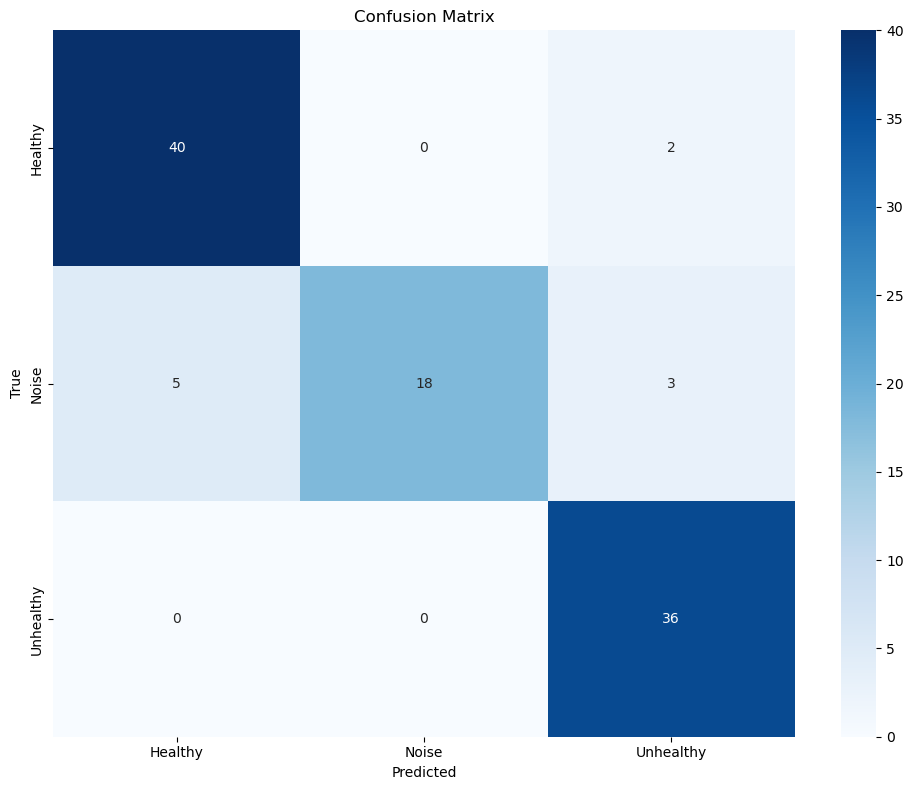


Per-Class Metrics:

Healthy:
  Sensitivity: 95.24%
  Specificity: 91.94%
  Precision: 88.89%
  NPV: 96.61%
  F1 Score: 91.95%
  MCC: 86.33%

Noise:
  Sensitivity: 69.23%
  Specificity: 100.00%
  Precision: 100.00%
  NPV: 90.70%
  F1 Score: 81.82%
  MCC: 79.24%

Unhealthy:
  Sensitivity: 100.00%
  Specificity: 92.65%
  Precision: 87.80%
  NPV: 100.00%
  F1 Score: 93.51%
  MCC: 90.19%

Average Metrics:
  Sensitivity: 88.16%
  Specificity: 94.86%
  Precision: 92.23%
  NPV: 95.77%
  F1 Score: 89.09%
  MCC: 85.26%


In [37]:
# Evaluate the model
print("\nEvaluating the model...")
metrics = evaluate_model(model, X_test, y_test, classes)

In [38]:
# Check if accuracy target is met
if metrics['accuracy'] >= 0.95:
    print("\nSuccess! The model achieved the target accuracy of 95% or higher.")
else:
    print(f"\nThe model achieved {metrics['accuracy'] * 100:.2f}% accuracy, which is below the target of 95%.")
    print("Consider trying the following improvements:")
    print("1. Adjust the burn intensity parameter")
    print("2. Try different audio preprocessing techniques")
    print("3. Implement more extensive data augmentation")
    print("4. Tune the model architecture")


The model achieved 90.38% accuracy, which is below the target of 95%.
Consider trying the following improvements:
1. Adjust the burn intensity parameter
2. Try different audio preprocessing techniques
3. Implement more extensive data augmentation
4. Tune the model architecture


## K-Fold Cross-Validation

Perform K-fold cross-validation as mentioned in the paper to get a robust estimate of model performance.

In [42]:
# Perform K-fold cross-validation
print("\nPerforming 5-fold cross-validation...")
fold_results, avg_acc, std_acc = k_fold_cross_validation(X_aug, y_aug, n_splits=5, epochs=5, batch_size=16)


Performing 5-fold cross-validation...

Training Fold 1/5
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4601 - loss: 1.4055

35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4612 - loss: 1.4035 - val_accuracy: 0.2230 - val_loss: 6.3982
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6093 - loss: 1.1365 - val_accuracy: 0.2230 - val_loss: 4.1474
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6702 - loss: 1.0618 - val_accuracy: 0.2230 - val_loss: 3.0559
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7317 - loss: 0.9148 - val_accuracy: 0.2230 - val_loss: 3.0989
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7336 - loss: 0.8774

35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7338 - loss: 0.8771 - val_accuracy: 0.2662 - val_loss: 2.1404
Fold 1 - Validation Loss: 2.1404, Validation Accuracy: 0.2662

Training Fold 2/5
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4676 - loss: 1.4598

35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4693 - loss: 1.4557 - val_accuracy: 0.4029 - val_loss: 3.4129
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6376 - loss: 1.1176 - val_accuracy: 0.2446 - val_loss: 2.8445
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7020 - loss: 1.0046 - val_accuracy: 0.2446 - val_loss: 1.9087
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7640 - loss: 0.9065 - val_accuracy: 0.3525 - val_loss: 1.3984
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7735 - loss: 0.8333

35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7735 - loss: 0.8329 - val_accuracy: 0.5036 - val_loss: 1.1712
Fold 2 - Validation Loss: 1.1712, Validation Accuracy: 0.5036

Training Fold 3/5
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4865 - loss: 1.3507

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4879 - loss: 1.3486 - val_accuracy: 0.2609 - val_loss: 3.7584
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6212 - loss: 1.1526

35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6224 - loss: 1.1504 - val_accuracy: 0.3333 - val_loss: 2.3001
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6467 - loss: 1.0555 - val_accuracy: 0.2536 - val_loss: 1.9614
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7250 - loss: 0.9139

35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7257 - loss: 0.9128 - val_accuracy: 0.4420 - val_loss: 1.2547
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7456 - loss: 0.8533 - val_accuracy: 0.3478 - val_loss: 2.3291
Fold 3 - Validation Loss: 1.2547, Validation Accuracy: 0.4420

Training Fold 4/5
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5278 - loss: 1.3435

35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5280 - loss: 1.3418 - val_accuracy: 0.2464 - val_loss: 4.2927
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6370 - loss: 1.0803 - val_accuracy: 0.2464 - val_loss: 3.3991
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6673 - loss: 1.0216 - val_accuracy: 0.2464 - val_loss: 1.8216
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7481 - loss: 0.8678 - val_accuracy: 0.2464 - val_loss: 1.9684
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7762 - loss: 0.8252

35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7762 - loss: 0.8254 - val_accuracy: 0.3261 - val_loss: 1.4659
Fold 4 - Validation Loss: 1.4659, Validation Accuracy: 0.3261

Training Fold 5/5
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4793 - loss: 1.3783

35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4802 - loss: 1.3757 - val_accuracy: 0.2681 - val_loss: 7.3104
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6099 - loss: 1.1227 - val_accuracy: 0.2681 - val_loss: 5.6870
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6570 - loss: 1.0292

35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6575 - loss: 1.0289 - val_accuracy: 0.3986 - val_loss: 2.3250
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7244 - loss: 0.9340 - val_accuracy: 0.2971 - val_loss: 1.8644
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7588 - loss: 0.8604

35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7591 - loss: 0.8602 - val_accuracy: 0.5870 - val_loss: 1.1019
Fold 5 - Validation Loss: 1.1019, Validation Accuracy: 0.5870

Cross-Validation Results:
Average Validation Loss: 1.4268
Average Validation Accuracy: 0.4250 ± 0.1164


## Save the Model

In [43]:
# Save the model
model.save('poultry_audio_classifier.h5')
print("Model saved as 'poultry_audio_classifier.h5'")

Model saved as 'poultry_audio_classifier.h5'


## Prediction Function for New Audio Files

In [ ]:
# Select a few test samples and make predictions
print("Making predictions on test samples:")

for i, class_name in enumerate(classes):
    class_indices = np.where(y_test == i)[0]
    if len(class_indices) > 0:
        sample_idx = np.random.choice(class_indices)
        sample_path = file_paths[np.where(y == y_test[sample_idx])[0][0]]
        print(f"\nPredicting a {class_name} sample:")
        predict_audio(model, sample_path, sr=sr, duration=duration, n_mfcc=n_mfcc, classes=classes)

## Conclusion

This notebook has implemented a deep learning-based approach for classifying poultry audio signals, using a custom Burn Layer as described in the paper. The model processes raw audio data, extracts relevant features, and uses a CNN architecture with Burn Layers to achieve high classification accuracy.

Key contributions include:
1. Implementation of the Burn Layer for enhanced model robustness
2. Comprehensive audio feature extraction and visualization
3. Data augmentation techniques for improved generalization
4. Evaluation metrics matching those in the paper